# Import Dependensi

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from numpy import hstack
import tensorflow as tf
from numpy import array
from datetime import datetime, timedelta
import matplotlib as mpl
from tensorflow import keras
from keras import optimizers
from keras.models import Sequential
from keras.layers import GRU, Dense, RepeatVector, TimeDistributed, Dropout, BatchNormalization, Activation
from sklearn.preprocessing import MinMaxScaler
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)

Matplotlib created a temporary cache directory at /var/folders/86/7gxks06s07xch2nsjg8bfzhh0000gn/T/matplotlib-vmy5u2nx because the default path (/Users/ingwerludwig/.matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


# Import Dataset

In [3]:
df = pd.read_excel('/Volumes/IngwerSSD/DATA/College/project-workspace/forecasting-dinas-sumber-daya air/Model Welang.xlsx','Data')
df.rename(columns={'Unnamed: 0': 'DateTime'}, inplace=True)
df['DateTime'] = pd.to_datetime(df['DateTime'])
df.sort_values(by='DateTime',ascending=True,inplace=True)
df

,DateTime,RC,RL,LP,LD
0,2022-09-20 20:00:00,0.0,0.0,0.107,0.315
1,2022-09-20 21:00:00,0.0,0.0,0.108,0.307
2,2022-09-20 22:00:00,0.0,0.0,0.106,0.297
3,2022-09-20 23:00:00,0.0,0.0,0.108,0.293
4,2022-09-21 00:00:00,0.0,0.0,0.111,0.292
...,...,...,...,...,...
8611,2023-09-15 08:00:00,0.0,0.0,0.070,0.213
8612,2023-09-15 09:00:00,0.0,0.0,0.080,0.228
8613,2023-09-15 10:00:00,0.0,0.0,0.089,0.237
8614,2023-09-15 11:00:00,0.0,0.0,0.096,0.245


# Isi Data yang tidak Sekuensial 1 Jam dengan Data Sebelumnya

In [4]:
check_df = df['DateTime']
check_df = pd.DataFrame(check_df)

check_df['TimeDifference'] = check_df['DateTime'].diff()
expected_interval = pd.to_timedelta('1 hour')
check_df['not_sequential'] = check_df['TimeDifference'] != expected_interval

check_df.at[0, 'not_sequential'] = False
filtered_df = check_df[check_df['not_sequential']]
filtered_df

,DateTime,TimeDifference,not_sequential
14,2022-09-21 11:00:00,0 days 02:00:00,True
15,2022-09-21 13:00:00,0 days 02:00:00,True
17,2022-09-21 16:00:00,0 days 02:00:00,True
65,2022-09-23 17:00:00,0 days 02:00:00,True
1386,2022-11-17 21:00:00,0 days 04:00:00,True
2158,2022-12-20 04:00:00,0 days 04:00:00,True
4254,2023-03-17 13:00:00,0 days 02:00:00,True
4303,2023-03-19 17:00:00,0 days 04:00:00,True
4397,2023-03-23 17:00:00,0 days 03:00:00,True
4465,2023-03-26 14:00:00,0 days 02:00:00,True


In [5]:
start_date = df['DateTime'].min()
end_date = df['DateTime'].max()
date_range = pd.date_range(start=start_date, end=end_date, freq='1H')
sequence_df = pd.DataFrame({'DateTime': date_range})

df = pd.merge_asof(sequence_df, df, on='DateTime', direction='backward')

# Forward-fill missing values in the 'Akumulasi Curah Hujan Cendono' column
df['RC'].fillna(method='ffill', inplace=True)
df['RC'] = df['RC'].round(3).astype(float)

df['RL'].fillna(method='ffill', inplace=True)
df['RL'] = df['RL'].round(3).astype(float)

df['LP'].fillna(method='ffill', inplace=True)
df['LP'] = df['LP'].round(3).astype(float)

df['LD'].fillna(method='ffill', inplace=True)
df['LD'] = df['LD'].round(3).astype(float)
df

,DateTime,RC,RL,LP,LD
0,2022-09-20 20:00:00,0.0,0.0,0.107,0.315
1,2022-09-20 21:00:00,0.0,0.0,0.108,0.307
2,2022-09-20 22:00:00,0.0,0.0,0.106,0.297
3,2022-09-20 23:00:00,0.0,0.0,0.108,0.293
4,2022-09-21 00:00:00,0.0,0.0,0.111,0.292
...,...,...,...,...,...
8628,2023-09-15 08:00:00,0.0,0.0,0.070,0.213
8629,2023-09-15 09:00:00,0.0,0.0,0.080,0.228
8630,2023-09-15 10:00:00,0.0,0.0,0.089,0.237
8631,2023-09-15 11:00:00,0.0,0.0,0.096,0.245


In [6]:
check_df = df['DateTime']
check_df = pd.DataFrame(check_df)

check_df['TimeDifference'] = check_df['DateTime'].diff()
expected_interval = pd.to_timedelta('1 hour')
check_df['not_sequential'] = check_df['TimeDifference'] != expected_interval

# Fill the first row with False since it doesn't have a previous row for comparison
check_df.at[0, 'not_sequential'] = False
filtered_df = check_df[check_df['not_sequential']]
filtered_df

,DateTime,TimeDifference,not_sequential


In [7]:
df.to_excel('Fix Data_Model Welang.xlsx')

# Load Dataset Baru

In [2]:
merge_df = pd.read_excel('Fix Data_Model Welang.xlsx')
merge_df.drop('Unnamed: 0',axis=1,inplace=True)
merge_df['DateTime'] = pd.to_datetime(merge_df['DateTime'])
merge_df.sort_values(by='DateTime',ascending=True,inplace=True)
merge_df

,DateTime,RC,RL,LP,LD
0,2022-09-20 20:00:00,0.0,0.0,0.107,0.315
1,2022-09-20 21:00:00,0.0,0.0,0.108,0.307
2,2022-09-20 22:00:00,0.0,0.0,0.106,0.297
3,2022-09-20 23:00:00,0.0,0.0,0.108,0.293
4,2022-09-21 00:00:00,0.0,0.0,0.111,0.292
...,...,...,...,...,...
8628,2023-09-15 08:00:00,0.0,0.0,0.070,0.213
8629,2023-09-15 09:00:00,0.0,0.0,0.080,0.228
8630,2023-09-15 10:00:00,0.0,0.0,0.089,0.237
8631,2023-09-15 11:00:00,0.0,0.0,0.096,0.245


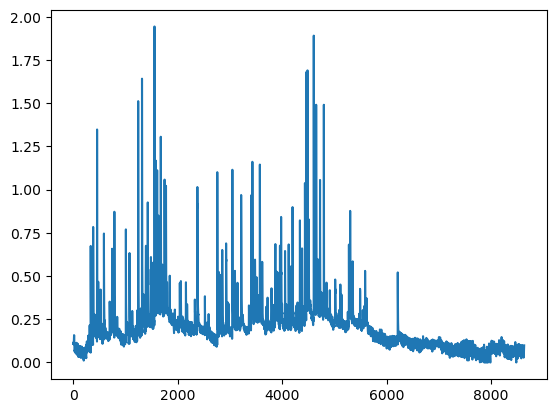

In [3]:
plt.plot(merge_df['LP'])

# Cek data dengan nilai 0 selain di Curah Hujan

In [4]:
columns_to_replace = [
    'LP',
    'LD'
]

mask = (merge_df[columns_to_replace] == 0).any(axis=1)
filtered_rows = merge_df[mask]
filtered_rows.sort_values(by='DateTime')

,DateTime,RC,RL,LP,LD
7866,2023-08-14 14:00:00,0.0,0.0,0.0,0.179
7884,2023-08-15 08:00:00,0.0,0.0,0.0,0.196
7885,2023-08-15 09:00:00,0.0,0.0,0.0,0.201
7886,2023-08-15 10:00:00,0.0,0.0,0.0,0.202
7887,2023-08-15 11:00:00,0.0,0.0,0.0,0.199
7888,2023-08-15 12:00:00,0.0,0.0,0.0,0.197
7889,2023-08-15 13:00:00,0.0,0.0,0.0,0.193
7890,2023-08-15 14:00:00,0.0,0.0,0.0,0.189
7907,2023-08-16 07:00:00,0.0,0.0,0.0,0.180
7908,2023-08-16 08:00:00,0.0,0.0,0.0,0.177


# Visualisasi Tren

In [5]:
from statsmodels.tsa.seasonal import seasonal_decompose
copy_df_2 = merge_df.iloc[48:144,:]
copy_df_2 = copy_df_2.set_index('DateTime')
copy_df_2.index.freq = 'H'

<Figure size 4200x2400 with 0 Axes>

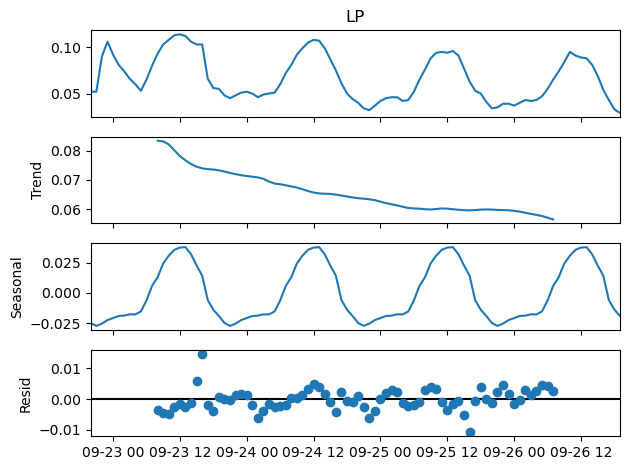

In [6]:
results = seasonal_decompose(copy_df_2['LP'])
plt.figure(figsize=(42, 24))
results.plot()
plt.show()

# Ekstrak Fitur Datetime untuk digunakan dalam TimeSeries Forecasting

In [7]:
test = merge_df.iloc[0:1,0]
test

0   2022-09-20 20:00:00
Name: DateTime, dtype: datetime64[ns]

In [8]:
print(test.dt.hour)

0    20
Name: DateTime, dtype: int64


In [9]:
merge_df['hour_at'] = merge_df['DateTime'].dt.hour
merge_df

,DateTime,RC,RL,LP,LD,hour_at
0,2022-09-20 20:00:00,0.0,0.0,0.107,0.315,20
1,2022-09-20 21:00:00,0.0,0.0,0.108,0.307,21
2,2022-09-20 22:00:00,0.0,0.0,0.106,0.297,22
3,2022-09-20 23:00:00,0.0,0.0,0.108,0.293,23
4,2022-09-21 00:00:00,0.0,0.0,0.111,0.292,0
...,...,...,...,...,...,...
8628,2023-09-15 08:00:00,0.0,0.0,0.070,0.213,8
8629,2023-09-15 09:00:00,0.0,0.0,0.080,0.228,9
8630,2023-09-15 10:00:00,0.0,0.0,0.089,0.237,10
8631,2023-09-15 11:00:00,0.0,0.0,0.096,0.245,11


# Visualisasi Jam Terhadap Rerata Muka Air Purwodadi

Text(0, 0.5, 'Rerata Tinggi Muka Air Purwodadi')

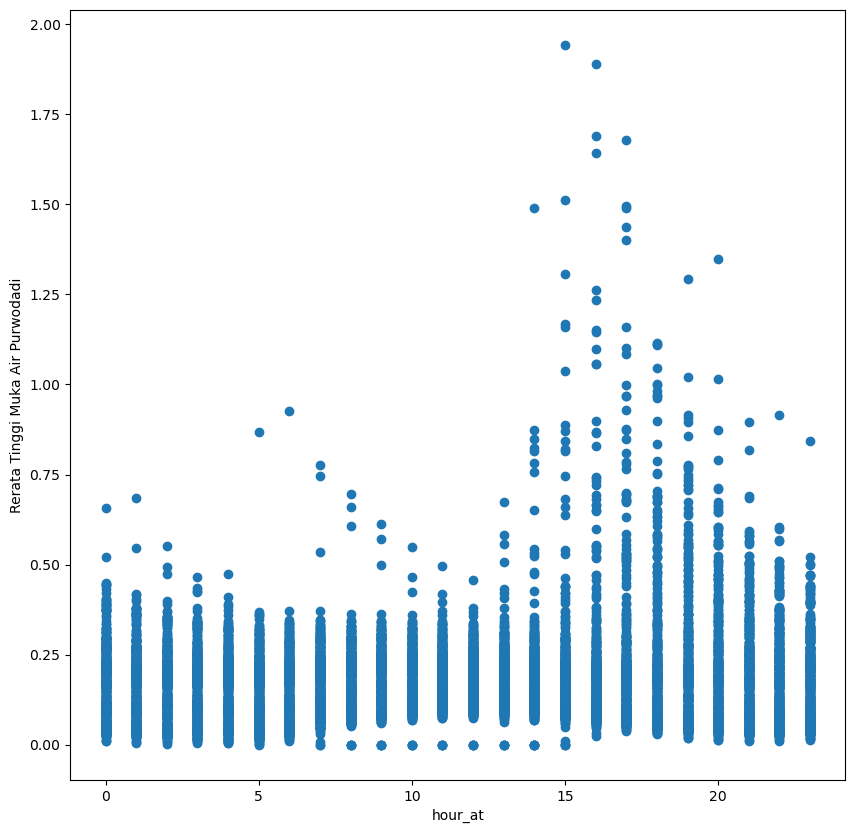

In [10]:
plt.figure(figsize=(10,10))
plt.scatter(x='hour_at',y='LP',data=merge_df)
plt.xlabel('hour_at')
plt.ylabel('Rerata Tinggi Muka Air Purwodadi')

# Mutivariat Sekuens untuk Input dan Output LSTM

In [11]:
def split_sequences_sliding(sequences, n_steps_in, n_steps_out, step=1):
    X, y = list(), list()
    for i in range(0, len(sequences) - n_steps_in - n_steps_out + 1, step):
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, :]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

# Train Test Split

In [12]:
merge_df.drop(['DateTime','hour_at','LD'],axis=1,inplace=True)
merge_df

,RC,RL,LP
0,0.0,0.0,0.107
1,0.0,0.0,0.108
2,0.0,0.0,0.106
3,0.0,0.0,0.108
4,0.0,0.0,0.111
...,...,...,...
8628,0.0,0.0,0.070
8629,0.0,0.0,0.080
8630,0.0,0.0,0.089
8631,0.0,0.0,0.096


In [13]:
from sklearn.model_selection import train_test_split
train_percent = 0.7
validation_percent = 0.2

new_merge_df = merge_df
train_size = int(len(new_merge_df) * train_percent)
validation_size = int(len(new_merge_df) * validation_percent)

df_train = new_merge_df[:train_size]
df_validation = new_merge_df[train_size:(train_size + validation_size)]
df_test = new_merge_df[train_size + validation_size:]

print('Data for train:', df_train.shape)
print('Total day for train:', df_train.shape[0]/24)
print('\nData for validation:', df_validation.shape)
print('Total day for validation:', df_validation.shape[0]/24)
print('\nData for test:', df_test.shape)
print('Total day for test:', df_test.shape[0]/24)

Data for train: (6043, 3)
Total day for train: 251.79166666666666

Data for validation: (1726, 3)
Total day for validation: 71.91666666666667

Data for test: (864, 3)
Total day for test: 36.0


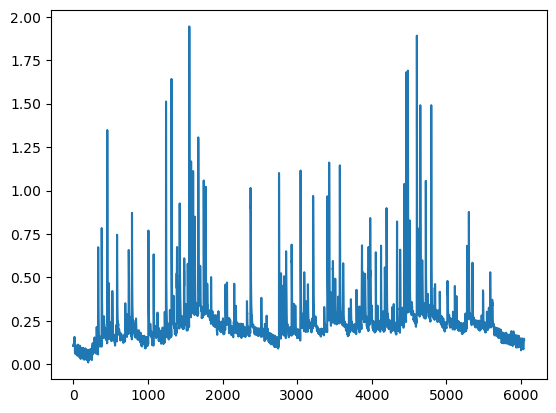

In [14]:
plt.plot(df_train['LP'])

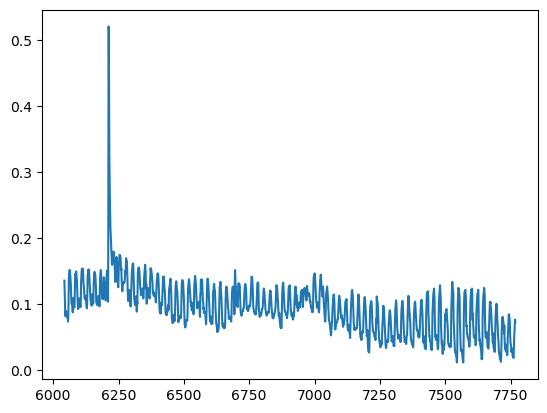

In [15]:
plt.plot(df_validation['LP'])

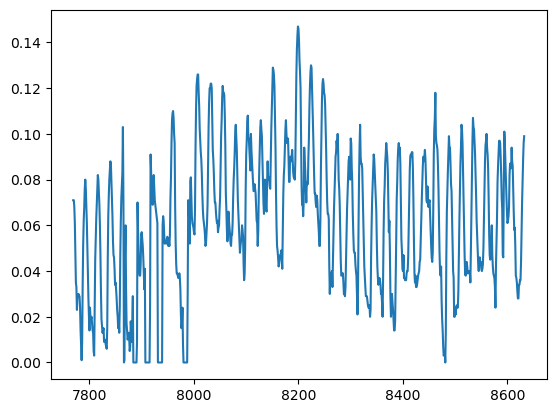

In [16]:
plt.plot(df_test['LP'])

# Konfigurasi Multivariat Sekuens Input / Output 

Menggunakan 6 jam sebelumnya untuk memprediksi 4 jam kedepan </br>
Contoh sekarang jam 07.00, data 01.00 - 06.00 akan digunakan untuk memprediksi data 08.00, 09.00, 10.00

In [17]:
x_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

n_steps_in, n_steps_out = 1, 1

x_train, y_train = split_sequences_sliding(df_train.to_numpy(), n_steps_in, n_steps_out)
x_train = x_train.reshape(-1, 3)
y_train = y_train[:, :, -1].reshape(-1, 1)

x_scaler.fit(x_train)
y_scaler.fit(y_train)
x_train_scaled = x_scaler.transform(x_train).reshape(-1, n_steps_in, 3)
y_train_scaled = y_scaler.transform(y_train)

x_val, y_val = split_sequences_sliding(df_validation.to_numpy(), n_steps_in, n_steps_out)
x_val = x_val.reshape(-1, 3)
y_val = y_val[:, :, -1].reshape(-1, 1)
x_val_scaled = x_scaler.transform(x_val).reshape(-1, n_steps_in, 3)
y_val_scaled = y_scaler.transform(y_val)

x_test, y_test = split_sequences_sliding(df_test.to_numpy(), n_steps_in, n_steps_out)
x_test = x_test.reshape(-1, 3)
y_test = y_test[:, :, -1].reshape(-1, 1)
x_test_scaled = x_scaler.transform(x_test).reshape(-1, n_steps_in, 3)
y_test_scaled = y_scaler.transform(y_test)

n_features = x_train.shape[1]

In [18]:
print('Total features:', n_features)
print('Total train data:', x_train_scaled.shape)
print('Total validation data:', x_val_scaled.shape)
print('Total test data:', x_test_scaled.shape)

Total features: 3
Total train data: (6042, 1, 3)
Total validation data: (1725, 1, 3)
Total test data: (863, 1, 3)


In [19]:
y_train.shape[1]

1

# Training Model

In [122]:
model = Sequential()

model.add(GRU(300, input_shape=(n_steps_in, n_features)))
model.add(RepeatVector(n_steps_out))
model.add(GRU(300, return_sequences=True))
model.add(Activation('relu'))
model.add(TimeDistributed(Dense(y_train.shape[1])))

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_6 (GRU)                 (None, 300)               274500    
                                                                 
 repeat_vector_3 (RepeatVec  (None, 1, 300)            0         
 tor)                                                            
                                                                 
 gru_7 (GRU)                 (None, 1, 300)            541800    
                                                                 
 activation_3 (Activation)   (None, 1, 300)            0         
                                                                 
 time_distributed_3 (TimeDi  (None, 1, 1)              301       
 stributed)                                                      
                                                                 
Total params: 816601 (3.12 MB)
Trainable params: 81660

# Model Tuning

In [123]:
from keras import backend as K

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 

# Fit Model

In [124]:
epoch = 50

model.compile(optimizer='adam', loss='mae', metrics='mae')
model.fit(x_train_scaled, y_train_scaled, batch_size=1, epochs=epoch,validation_data=(x_val_scaled, y_val_scaled))

Epoch 1/50
6042/6042 [==============================] - 80s 13ms/step - loss: 0.0135 - mae: 0.0135 - val_loss: 0.0066 - val_mae: 0.0066
Epoch 2/50
6042/6042 [==============================] - 79s 13ms/step - loss: 0.0121 - mae: 0.0121 - val_loss: 0.0050 - val_mae: 0.0050
Epoch 3/50
6042/6042 [==============================] - 78s 13ms/step - loss: 0.0115 - mae: 0.0115 - val_loss: 0.0038 - val_mae: 0.0038
Epoch 4/50
6042/6042 [==============================] - 78s 13ms/step - loss: 0.0111 - mae: 0.0111 - val_loss: 0.0051 - val_mae: 0.0051
Epoch 5/50
6042/6042 [==============================] - 78s 13ms/step - loss: 0.0109 - mae: 0.0109 - val_loss: 0.0060 - val_mae: 0.0060
Epoch 6/50
6042/6042 [==============================] - 78s 13ms/step - loss: 0.0107 - mae: 0.0107 - val_loss: 0.0063 - val_mae: 0.0063
Epoch 7/50
6042/6042 [==============================] - 79s 13ms/step - loss: 0.0107 - mae: 0.0107 - val_loss: 0.0051 - val_mae: 0.0051
Epoch 8/50
6042/6042 [==========================

# Test Model

In [125]:
predictions = y_scaler.inverse_transform(model.predict_generator(x_test_scaled).reshape(-1,1))
print(predictions.shape)
print(y_test.shape)

(863, 1)
(863, 1)


In [126]:
predictions_train = y_scaler.inverse_transform(model.predict_generator(x_train_scaled).reshape(-1,1))
print(predictions_train.shape)
print(y_train.shape)

(6042, 1)
(6042, 1)


# Bentuk Prediksi ke Dataframe

In [127]:
real = y_test
real_train = y_train

# rescale predictions
predictions = pd.DataFrame(predictions)
predictions = predictions
predictions = pd.DataFrame(predictions)

predictions_for_train = pd.DataFrame(predictions_train)
predictions_for_train = predictions_train
predictions_for_train = pd.DataFrame(predictions_train)

real = pd.DataFrame(real)
real = real
real = pd.DataFrame(real)

real_train = pd.DataFrame(real_train)
real_train =real_train
real_train = pd.DataFrame(real_train)

print(predictions.shape)
print(real.shape)

print(predictions_for_train.shape)
print(real_train.shape)

(863, 1)
(863, 1)
(6042, 1)
(6042, 1)


In [128]:
df_final = pd.DataFrame()
df_final_train = pd.DataFrame()

In [129]:
df_final['Tinggi Muka Air Purwodadi'] = real[0]
df_final['Prediksi Tinggi Muka Air Purwodadi'] = predictions[0]

In [130]:
df_final_train['Tinggi Muka Air Purwodadi'] = real_train[0]
df_final_train['Prediksi Tinggi Muka Air Purwodadi'] = predictions_for_train[0]

# Plot Model Test Dataset

<Axes: >

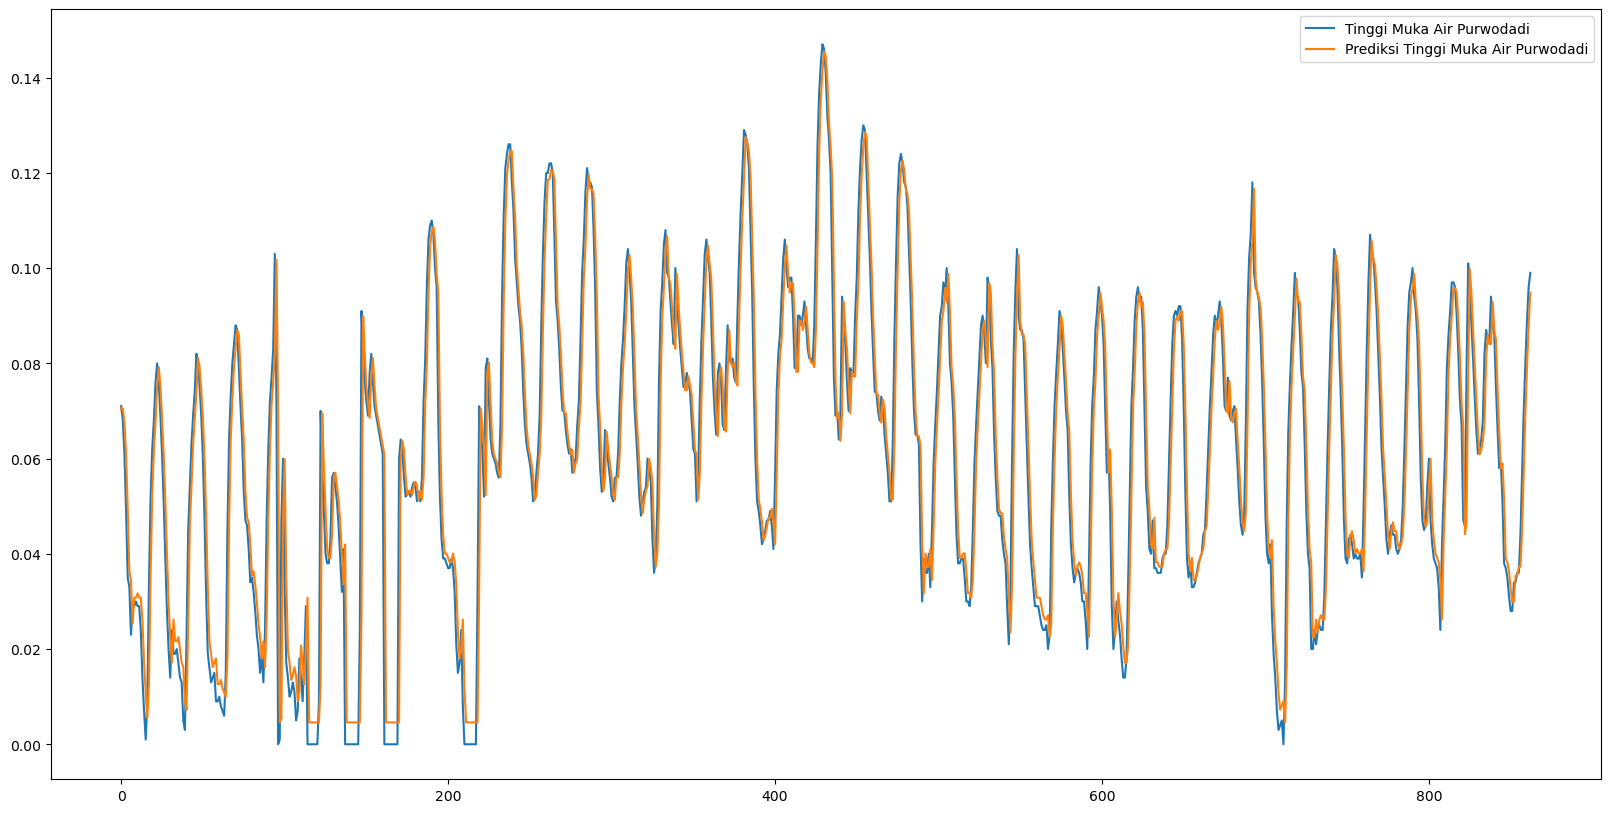

In [131]:
mpl.rcParams['figure.figsize'] = (20,10)
mpl.rcParams['axes.grid'] = False
df_final[['Tinggi Muka Air Purwodadi', 'Prediksi Tinggi Muka Air Purwodadi']].plot()

# Plot Model Train Dataset

<Axes: >

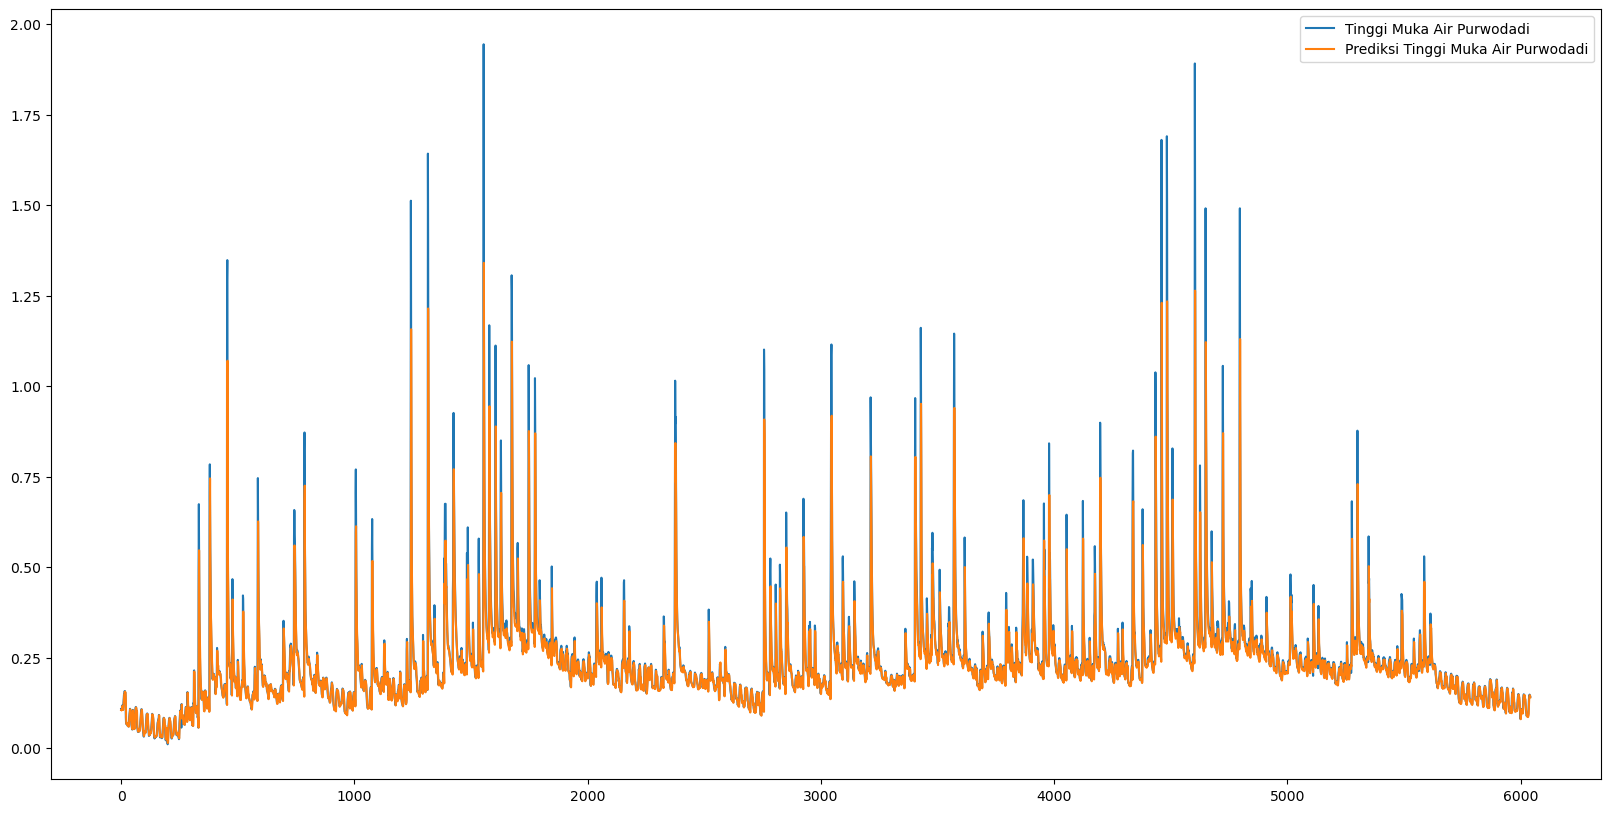

In [132]:
mpl.rcParams['figure.figsize'] = (20,10)
mpl.rcParams['axes.grid'] = False
df_final_train[['Tinggi Muka Air Purwodadi', 'Prediksi Tinggi Muka Air Purwodadi']].plot()

# Evaluation Score

In [133]:
rmse_scores = []
model_names = []
mse_scores = []
mape_scores = []
mae_scores = []

In [134]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_percentage_error

indicator = [ 'Tinggi Muka Air Purwodadi']

for i in indicator:
  rmse_scores.append(mean_squared_error(df_final[f'{i}'],df_final[f'Prediksi {i}'], squared=False))
  mse_scores.append(mean_squared_error(df_final[f'{i}'],df_final[f'Prediksi {i}']))
  mae_scores.append(mean_absolute_error(df_final[f'{i}'], df_final[f'Prediksi {i}']))
  mape_scores.append(mean_absolute_percentage_error(df_final[f'{i}'], df_final[f'Prediksi {i}']))
  model_names.append(i)

In [135]:
data = {'Fitur Yang Akan Diprediksi': model_names, 'RMSE Score Prediction': rmse_scores, 'MSE Score Prediction': mse_scores,'MAE Score Prediction': mae_scores, 'MAPE Score Prediction' : mape_scores}
df_evaluation = pd.DataFrame(data)
df_evaluation = df_evaluation.sort_values(by='RMSE Score Prediction', ascending=True)
pd.set_option('display.float_format', '{:.2f}'.format)
df_evaluation

,Fitur Yang Akan Diprediksi,RMSE Score Prediction,MSE Score Prediction,MAE Score Prediction,MAPE Score Prediction
0,Tinggi Muka Air Purwodadi,0.01,0.00,0.01,1867755791522.72


In [136]:
df_evaluation.to_excel('GRU_RNN_result.xlsx')

# Perbandingan Selisih Dalam Angka

In [137]:
df_final = df_final.round(2)

df_final['Difference_Rerata'] = abs(df_final['Tinggi Muka Air Purwodadi'] - df_final['Prediksi Tinggi Muka Air Purwodadi'])
df_final

,Tinggi Muka Air Purwodadi,Prediksi Tinggi Muka Air Purwodadi,Difference_Rerata
0,0.07,0.07,0.00
1,0.07,0.07,0.00
2,0.06,0.07,0.01
3,0.05,0.06,0.01
4,0.04,0.05,0.01
...,...,...,...
858,0.07,0.06,0.01
859,0.08,0.07,0.01
860,0.09,0.08,0.01
861,0.10,0.09,0.01


In [138]:
test = df_final.sort_values(by='Difference_Rerata', ascending=False)
test[test['Difference_Rerata']>0.10].head(20)

,Tinggi Muka Air Purwodadi,Prediksi Tinggi Muka Air Purwodadi,Difference_Rerata


# Save Model

In [139]:
model.save_weights('./checkpoints/my_checkpoint')

In [140]:
!mkdir -p saved_model
model.save('saved_model/muka_air_purwodadi/gru-ffws-model-batch-1-300-1-hari')
model.save('purwodadi_gru-model.h5')

INFO:tensorflow:Assets written to: saved_model/muka_air_purwodadi/gru-ffws-model-batch-1-300-1-hari/assets


INFO:tensorflow:Assets written to: saved_model/muka_air_purwodadi/gru-ffws-model-batch-1-300-1-hari/assets


In [20]:
import pickle
with open('purwodadi_gru_x_scaler.pkl', 'wb') as file:
    pickle.dump(x_scaler, file)
    
with open('purwodadi_gru_y_scaler.pkl', 'wb') as file:
    pickle.dump(y_scaler, file)